# Find outliers with unusual entropy
Inspired by the pre-processing step from the paper http://openaccess.thecvf.com/content_cvpr_2018/CameraReady/2763.pdf

> <b>Noise Removal with Image Entropy</b>
> Key ingredient to a successful sketch center loss is the guarantee of non-noisy data (outliers), as it will significantly affect the class feature centers. However, sketch data collected with crowdsourcing are inevitable to noise, where we propose a noisy data removal technique to alleviate such issue by resorting to image entropy. Given a category of sketch, we can get entropy for each sketch and the overall entropy distribution on a category basis. We empirically find that keeping the middle 90% of each category as normal samples gives us best results. In Figure 4, we visualize the entropy histogram of star samples in our training set. If we choose the middle 90% samples as normal samples for star category, we can calculate and get the 0.05 and 0.95 percentiles of star images entropy as 0.1051 and 0.1721, respectively. We then treat the remaining samples as outliers or noise points (entropy ∈ [0, 0.1051)   (0.1721, 1]). It can be observed that low entropy sketches tend to be overly-abstract, yet high entropy ones being messy, sometimes with meaningless scribbles. Nevertheless, sketch data falling into middle entropy range present more consistent and reasonable drawings.


In [1]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dask import bag
from tqdm import tqdm
from PIL import Image, ImageDraw
import cv2

In [2]:
def entropy_it(x):
    counts = np.bincount(x)
    p = counts[counts > 0] / float(len(x))
    # compute Shannon entropy in bits
    return -np.sum(p * np.log2(p))

def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            draw.line([stroke[0][i], stroke[1][i], stroke[0][i+1], stroke[1][i+1]], fill=0, width=5)
    image = np.array(image)
    return entropy_it(image.flatten()), image

def data_draw_cv2(raw_strokes, size=96, linewidth=6, time_color=True):
    img = np.zeros((256, 256), np.uint8)
    for t, stroke in enumerate(ast.literal_eval(raw_strokes)):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), 
                         (stroke[0][i + 1], stroke[1][i + 1]), color, linewidth,cv2.LINE_AA)
    if size != 256:
        img = cv2.resize(img, (size, size))
        
    img = np.array(img)
    return entropy_it(img.flatten()), img

def plot_it(entropy, images, indices, n=5):
    fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(12, 10))
    for i, j in enumerate(indices[0][:n*n]):
        ax = axs[i // n, i % n]
        ax.set_title("%.4f" % entropy[j])
        ax.imshow(images[j])
        ax.set_yticks([])
        ax.set_xticks([])
        plt.setp(ax.spines.values(), color="red")
    plt.subplots_adjust(bottom=-0.2)
    plt.show()

In [3]:
reader = pd.read_csv('../drawquick/input/train_simplified/mug.csv', index_col=['key_id'], chunksize=1024)

data = []
for chunk in tqdm(reader):
    entropybag = bag.from_sequence(chunk.drawing.values).map(data_draw_cv2)
    data.extend(entropybag.compute()) # PARALLELIZE

entropy, images = zip(*data)

150it [00:55,  2.25it/s]


## Keep 98% of samples

In [8]:
threshold = 1

lower = np.percentile(entropy, 5)
upper = np.percentile(entropy, 100 - 2)
print(np.min(entropy), np.max(entropy))
print(lower, upper)

0.012467008412627309 4.686696562416357
1.0898423269594804 2.1343388154261924


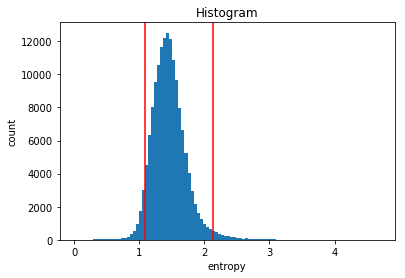

In [9]:
plt.title("Histogram")
plt.xlabel('entropy')
plt.ylabel('count')
plt.hist(entropy, bins=100)
plt.axvline(x=lower, color='r')
plt.axvline(x=upper, color='r')

## Low entropy samples

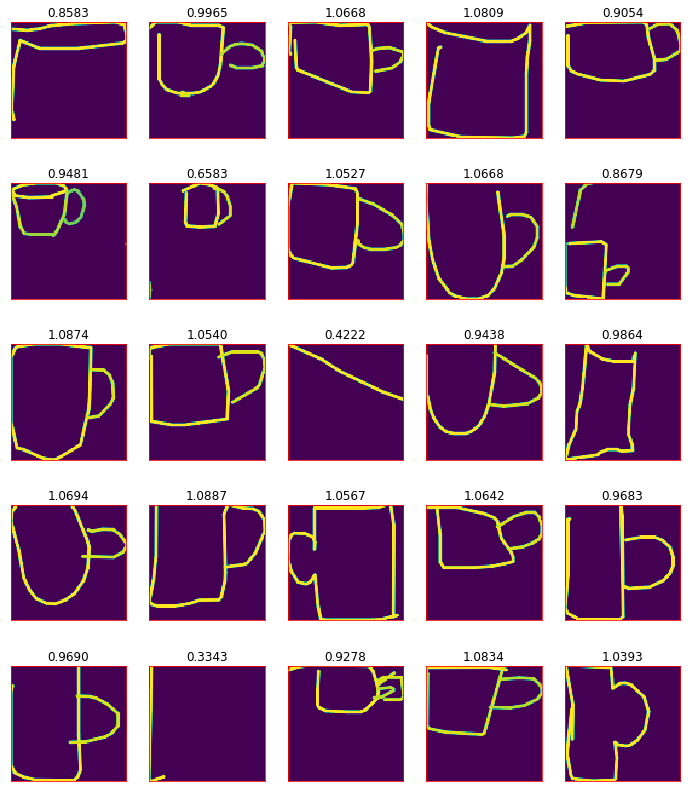

In [10]:
plot_it(entropy, images, np.where(entropy < lower))

## High entropy samples

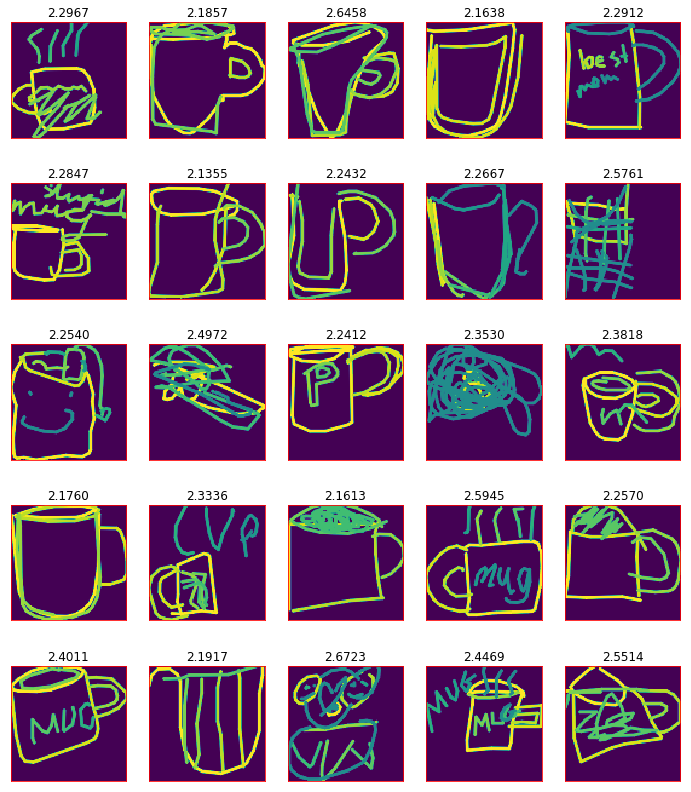

In [11]:
plot_it(entropy, images, np.where(entropy > upper))